# Emojify! 

Welcome to the assignment. You are going to use word vector representations to build an Emojifier. 

Have you ever wanted to make your text messages more expressive? Your emojifier app will help you do that. So rather than writing "Congratulations on the promotion! Lets get coffee and talk. Love you!" the emojifier can automatically turn this into "Congratulations on the promotion! 👍 Lets get coffee and talk. ☕️ Love you! ❤️"

Alternativly, if you're not excited about emojis but have had friends that sent you crazy text messages that used far too many emojis, you can also use the emojifier to get back at them.  

You will implement a model which inputs a sentence (such as "Let's go see the baseball game tonight!") and finds the most appropriate emoji to be used with this sentence (⚾️). In many emoji interfaces, you need to remember that ❤️ is the "heart" symbol rather than the "love" symbol. But using word vectors, you'll see that even if your training set explicitly relates only a few words to a particular emoji, your algorithm will be able to generalize and associate words in the test set to the same emoji even if those words don't even appear in the training set. This allows you to build an accurate classifier mapping from sentences to emojis, even using a small training set. 

In this exercise, you'll start with a baseline model (Emojifier-V1) using word embeddings, then build a more sophisticated model (Emojifier-V2) that further incorporates an LSTM. 

Lets get started! Run the following cell to load the package you are going to use. 

In [1]:
pip install emoji --upgrade

Requirement already up-to-date: emoji in /usr/local/lib/python3.6/dist-packages (0.5.4)


In [10]:
!pip install kaggle
import json
import zipfile
import os
os.environ['KAGGLE_USERNAME'] = "XXXXXX"
os.environ['KAGGLE_KEY'] = "XXXXXX"
!kaggle datasets download -d maximilianhahn/glove50d/download
for file in os.listdir():
  if file.endswith('zip'):
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall()
    zip_ref.close()

 83% 56.0M/67.7M [00:01<00:00, 32.4MB/s]
100% 67.7M/67.7M [00:01<00:00, 51.9MB/s]


In [0]:
import numpy as np
import emo_utils
#from emo_utils import emo_utils
import emoji
import matplotlib.pyplot as plt
import re
import pandas as pd

%matplotlib inline

## 1 - Baseline model: Emojifier-V1

### 1.1 - Dataset EMOJISET

Let's start by building a simple baseline classifier. 

You have a tiny dataset (X, Y) where:
- X contains 127 sentences (strings)
- Y contains a integer label between 0 and 4 corresponding to an emoji for each sentence

<img src="https://github.com/MykhailoFokin/ml_course/blob/master/NLP_and_word_embeddings/images/data_set.png?raw=1" style="width:700px;height:300px;">
<caption><center> **Figure 1**: EMOJISET - a classification problem with 5 classes. A few examples of sentences are given here. </center></caption>

Let's load the dataset using the code below. We split the dataset between training (127 examples) and testing (56 examples).

In [0]:
X_train, Y_train = emo_utils.read_csv('data/train_emoji.csv')
X_test, Y_test = emo_utils.read_csv('data/tesss.csv')

In [0]:
maxLen = len(max(X_train, key=len).split())

Run the following cell to print sentences from X_train and corresponding labels from Y_train. Change `index` to see different examples. Because of the font the iPython notebook uses, the heart emoji may be colored black rather than red.

In [17]:
index = 1
print(X_train[index], emo_utils.label_to_emoji(Y_train[index]))

I am proud of your achievements 😄


### 1.2 - Overview of the Emojifier-V1

In this part, you are going to implement a baseline model called "Emojifier-v1".  

<center>
<img src="https://github.com/MykhailoFokin/ml_course/blob/master/NLP_and_word_embeddings/images/image_1.png?raw=1" style="width:900px;height:300px;">
<caption><center> **Figure 2**: Baseline model (Emojifier-V1).</center></caption>
</center>

The input of the model is a string corresponding to a sentence (e.g. "I love you). In the code, the output will be a probability vector of shape (1,5), that you then pass in an argmax layer to extract the index of the most likely emoji output.

To get our labels into a format suitable for training a softmax classifier, lets convert $Y$ from its current shape  current shape $(m, 1)$ into a "one-hot representation" $(m, 5)$, where each row is a one-hot vector giving the label of one example, You can do so using this next code snipper. Here, `Y_oh` stands for "Y-one-hot" in the variable names `Y_oh_train` and `Y_oh_test`: 


In [0]:
Y_oh_train = emo_utils.convert_to_one_hot(Y_train, C = 5)
Y_oh_test = emo_utils.convert_to_one_hot(Y_test, C = 5)

Let's see what `convert_to_one_hot()` did. Feel free to change `index` to print out different values. 

In [19]:
index = 50
print(Y_train[index], "is converted into one hot", Y_oh_train[index])

0 is converted into one hot [1. 0. 0. 0. 0.]


All the data is now ready to be fed into the Emojify-V1 model. Let's implement the model!

### 1.3 - Implementing Emojifier-V1

As shown in Figure (2), the first step is to convert an input sentence into the word vector representation, which then get averaged together. Similar to the previous exercise, we will use pretrained 50-dimensional GloVe embeddings. Run the following cell to load the `word_to_vec_map`, which contains all the vector representations.

In [0]:
word_to_index, index_to_word, word_to_vec_map = emo_utils.read_glove_vecs('glove.6B.50d.txt')

You've loaded:
- `word_to_index`: dictionary mapping from words to their indices in the vocabulary (400,001 words, with the valid indices ranging from 0 to 400,000)
- `index_to_word`: dictionary mapping from indices to their corresponding words in the vocabulary
- `word_to_vec_map`: dictionary mapping words to their GloVe vector representation.

Run the following cell to check if it works.

In [22]:
word = "cucumber"
index = 289846
print("the index of", word, "in the vocabulary is", word_to_index[word])
print("the", str(index) + "th word in the vocabulary is", index_to_word[index])

the index of cucumber in the vocabulary is 113317
the 289846th word in the vocabulary is potatos


**Exercise**: Implement `sentence_to_avg()`. You will need to carry out two steps:
1. Convert every sentence to lower-case, then split the sentence into a list of words. `X.lower()` and `X.split()` might be useful. 
2. For each word in the sentence, access its GloVe representation. Then, average all these values.

In [0]:
# GRADED FUNCTION: sentence_to_avg

def sentence_to_avg(sentence, word_to_vec_map):
    """
    Converts a sentence (string) into a list of words (strings). Extracts the GloVe representation of each word
    and averages its value into a single vector encoding the meaning of the sentence.
    
    Arguments:
    sentence -- string, one training example from X
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    
    Returns:
    avg -- average vector encoding information about the sentence, numpy-array of shape (50,)
    """
    
    ### START CODE HERE ###
    # Step 1: Split sentence into list of lower case words (≈ 1 line)
    words = sentence.lower().split()

    # Initialize the average word vector, should have the same shape as your word vectors.
    avg = np.zeros(50)
    
    # Step 2: average the word vectors. You can loop over the words in the list "words".
    for w in words:
        avg += word_to_vec_map[w]
    avg = avg/len(words)
    
    ### END CODE HERE ###
    
    return avg

In [25]:
avg = sentence_to_avg("Morrocan couscous is my favorite dish", word_to_vec_map)
print("avg = ", avg)

avg =  [-0.008005    0.56370833 -0.50427333  0.258865    0.55131103  0.03104983
 -0.21013718  0.16893933 -0.09590267  0.141784   -0.15708967  0.18525867
  0.6495785   0.38371117  0.21102167  0.11301667  0.02613967  0.26037767
  0.05820667 -0.01578167 -0.12078833 -0.02471267  0.4128455   0.5152061
  0.38756167 -0.898661   -0.535145    0.33501167  0.68806933 -0.2156265
  1.797155    0.10476933 -0.36775333  0.750785    0.10282583  0.348925
 -0.27262833  0.66768    -0.10706167 -0.283635    0.59580117  0.28747333
 -0.3366635   0.23393817  0.34349183  0.178405    0.1166155  -0.076433
  0.1445417   0.09808667]


**Expected Output**:

<table>
    <tr>
        <td>
            **avg= **
        </td>
        <td>
           [-0.008005    0.56370833 -0.50427333  0.258865    0.55131103  0.03104983
 -0.21013718  0.16893933 -0.09590267  0.141784   -0.15708967  0.18525867
  0.6495785   0.38371117  0.21102167  0.11301667  0.02613967  0.26037767
  0.05820667 -0.01578167 -0.12078833 -0.02471267  0.4128455   0.5152061
  0.38756167 -0.898661   -0.535145    0.33501167  0.68806933 -0.2156265
  1.797155    0.10476933 -0.36775333  0.750785    0.10282583  0.348925
 -0.27262833  0.66768    -0.10706167 -0.283635    0.59580117  0.28747333
 -0.3366635   0.23393817  0.34349183  0.178405    0.1166155  -0.076433
  0.1445417   0.09808667]
        </td>
    </tr>
</table>

#### Model

You now have all the pieces to finish implementing the `model()` function. After using `sentence_to_avg()` you need to pass the average through forward propagation, compute the cost, and then backpropagate to update the softmax's parameters. 

**Exercise**: Implement the `model()` function described in Figure (2). Assuming here that $Yoh$ ("Y one hot") is the one-hot encoding of the output labels, the equations you need to implement in the forward pass and to compute the cross-entropy cost are:
$$ z^{(i)} = W \times avg^{(i)} + b$$
$$ a^{(i)} = softmax(z^{(i)})$$
$$ \mathcal{L}^{(i)} = - \sum_{k = 0}^{n_y - 1} Yoh^{(i)}_k * log(a^{(i)}_k)$$

It is possible to come up with a more efficient vectorized implementation. But since we are using a for-loop to convert the sentences one at a time into the avg^{(i)} representation anyway, let's not bother this time. 

We provided you a function `softmax()`.

In [0]:
# GRADED FUNCTION: model

def model(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 400):
    """
    Model to train word vector representations in numpy.
    
    Arguments:
    X -- input data, numpy array of sentences as strings, of shape (m, 1)
    Y -- labels, numpy array of integers between 0 and 7, numpy-array of shape (m, 1)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    learning_rate -- learning_rate for the stochastic gradient descent algorithm
    num_iterations -- number of iterations
    
    Returns:
    pred -- vector of predictions, numpy-array of shape (m, 1)
    W -- weight matrix of the softmax layer, of shape (n_y, n_h)
    b -- bias of the softmax layer, of shape (n_y,)
    """
    
    np.random.seed(1)

    # Define number of training examples
    m = Y.shape[0]                          # number of training examples
    n_y = 5                                 # number of classes  
    n_h = 50                                # dimensions of the GloVe vectors 
    
    # Initialize parameters using Xavier initialization
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,))
    
    # Convert Y to Y_onehot with n_y classes
    Y_oh = emo_utils.convert_to_one_hot(Y, C = n_y) 
    
    # Optimization loop
    for t in range(num_iterations):                       # Loop over the number of iterations
        for i in range(m):                                # Loop over the training examples
            
            ### START CODE HERE ### (≈ 4 lines of code)
            # Average the word vectors of the words from the j'th training example
            avg = sentence_to_avg(X[i], word_to_vec_map)

            # Forward propagate the avg through the softmax layer
            z = np.dot(W, avg) + b
            a = emo_utils.softmax(z)

            # Compute cost using the j'th training label's one hot representation and "A" (the output of the softmax)
            cost = -1*np.dot(Y_oh[i], np.log(a))
            ### END CODE HERE ###
            
            # Compute gradients 
            dz = a - Y_oh[i]
            dW = np.dot(dz.reshape(n_y,1), avg.reshape(1, n_h))
            db = dz

            # Update parameters with Stochastic Gradient Descent
            W = W - learning_rate * dW
            b = b - learning_rate * db
        
        if t % 100 == 0:
            print("Epoch: " + str(t) + " --- cost = " + str(cost))
            pred = emo_utils.predict(X, Y, W, b, word_to_vec_map)

    return pred, W, b

In [27]:
print(X_train.shape)
print(Y_train.shape)
print(np.eye(5)[Y_train.reshape(-1)].shape)
print(X_train[0])
print(type(X_train))
Y = np.asarray([5,0,0,5, 4, 4, 4, 6, 6, 4, 1, 1, 5, 6, 6, 3, 6, 3, 4, 4])
print(Y.shape)

X = np.asarray(['I am going to the bar tonight', 'I love you', 'miss you my dear',
 'Lets go party and drinks','Congrats on the new job','Congratulations',
 'I am so happy for you', 'Why are you feeling bad', 'What is wrong with you',
 'You totally deserve this prize', 'Let us go play football',
 'Are you down for football this afternoon', 'Work hard play harder',
 'It is suprising how people can be dumb sometimes',
 'I am very disappointed','It is the best day in my life',
 'I think I will end up alone','My life is so boring','Good job',
 'Great so awesome'])

(132,)
(132,)
(132, 5)
never talk to me again
<class 'numpy.ndarray'>
(20,)


Run the next cell to train your model and learn the softmax parameters (W,b). 

In [33]:
pred, W, b = model(X_train, Y_train, word_to_vec_map)
#print(pred)

Epoch: 0 --- cost = 1.9520498812810076
Accuracy: 0.3484848484848485
Epoch: 100 --- cost = 0.07971818726014794
Accuracy: 0.9318181818181818
Epoch: 200 --- cost = 0.04456369243681402
Accuracy: 0.9545454545454546
Epoch: 300 --- cost = 0.03432267378786059
Accuracy: 0.9696969696969697


**Expected Output** (on a subset of iterations):

<table>
    <tr>
        <td>
            **Epoch: 0**
        </td>
        <td>
           cost = 1.95204988128
        </td>
        <td>
           Accuracy: 0.348484848485
        </td>
    </tr>


<tr>
        <td>
            **Epoch: 100**
        </td>
        <td>
           cost = 0.0797181872601
        </td>
        <td>
           Accuracy: 0.931818181818
        </td>
    </tr>
    
<tr>
        <td>
            **Epoch: 200**
        </td>
        <td>
           cost = 0.0445636924368
        </td>
        <td>
           Accuracy: 0.954545454545
        </td>
    </tr>
    
    <tr>
        <td>
            **Epoch: 300**
        </td>
        <td>
           cost = 0.0343226737879
        </td>
        <td>
           Accuracy: 0.969696969697
        </td>
    </tr>
</table>

Great! Your model has pretty high accuracy on the training set. Lets now see how it does on the test set. 

### 1.4 - Examining test set performance 


In [35]:
print("Training set:")
pred_train = emo_utils.predict(X_train, Y_train, W, b, word_to_vec_map)
print('Test set:')
pred_test = emo_utils.predict(X_test, Y_test, W, b, word_to_vec_map)

Training set:
Accuracy: 0.9772727272727273
Test set:
Accuracy: 0.8571428571428571


**Expected Output**:

<table>
    <tr>
        <td>
            **Train set accuracy**
        </td>
        <td>
           97.7
        </td>
    </tr>
    <tr>
        <td>
            **Test set accuracy**
        </td>
        <td>
           85.7
        </td>
    </tr>
</table>

Random guessing would have had 20% accuracy given that there are 5 classes. This is pretty good performance after training on only 127 examples. 

In the training set, the algorithm saw the sentence "*I love you*" with the label ❤️. You can check however that the word "adore" does not appear in the training set. Nonetheless, lets see what happens if you write "*I adore you*."



In [36]:
X_my_sentences = np.array(["i adore you", "i love you", "funny lol", "lets play with a ball", "food is ready", "you are not happy"])
Y_my_labels = np.array([[0], [0], [2], [1], [4],[3]])

pred = emo_utils.predict(X_my_sentences, Y_my_labels , W, b, word_to_vec_map)
emo_utils.print_predictions(X_my_sentences, pred)

Accuracy: 0.8333333333333334

i adore you ❤️
i love you ❤️
funny lol 😄
lets play with a ball ⚾
food is ready 🍴
you are not happy ❤️


Amazing! Because *adore* has a similar embedding as *love*, the algorithm has generalized correctly even to a word it has never seen before. Words such as *heart*, *dear*, *beloved* or *adore* have embedding vectors similar to *love*, and so might work too---feel free to modify the inputs above and try out a variety of input sentences. How well does it work?

Note though that it doesn't get "you are not happy" correct. This algorithm ignores word ordering, so is not good at understanding phrases like "not happy." 

Printing the confusion matrix can also help understand which classes are more difficult for your model. A confusion matrix shows how often an example whose label is one class ("actual" class) is mislabeled by the algorithm with a different class ("predicted" class). 




(56,)
           ❤️    ⚾    😄    😞   🍴
Predicted  0.0  1.0  2.0  3.0  4.0  All
Actual                                 
0            6    0    0    1    0    7
1            0    8    0    0    0    8
2            2    0   16    0    0   18
3            1    1    2   12    0   16
4            0    0    1    0    6    7
All          9    9   19   13    6   56


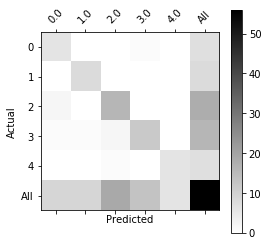

In [39]:
print(Y_test.shape)
print('           '+ emo_utils.label_to_emoji(0)+ '    ' + emo_utils.label_to_emoji(1) + '    ' +  emo_utils.label_to_emoji(2)+ '    ' + emo_utils.label_to_emoji(3)+'   ' + emo_utils.label_to_emoji(4))
print(pd.crosstab(Y_test, pred_test.reshape(56,), rownames=['Actual'], colnames=['Predicted'], margins=True))
emo_utils.plot_confusion_matrix(Y_test, pred_test)

<font color='blue'>
**What you should remember from this part**:
- Even with a 127 training examples, you can get a reasonably good model for Emojifying. This is due to the generalization power word vectors gives you. 
- Emojify-V1 will perform poorly on sentences such as *"This movie is not good and not enjoyable"* because it doesn't understand combinations of words--it just averages all the words' embedding vectors together, without paying attention to the ordering of words. You will build a better algorithm in the next part. 


## 2 - Emojifier-V2: Using LSTMs in Keras: 

Let's build an LSTM model that takes as input word sequences. This model will be able to take word ordering into account. Emojifier-V2 will continue to use pre-trained word embeddings to represent words, but will feed them into an LSTM, whose job it is to predict the most appropriate emoji. 

Run the following cell to load the Keras packages.

In [40]:
import numpy as np
np.random.seed(0)
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
np.random.seed(1)

Using TensorFlow backend.


In [0]:
from keras.initializers import glorot_uniform

### 2.1 - Overview of the model

Here is the Emojifier-v2 you will implement:

<img src="https://github.com/MykhailoFokin/ml_course/blob/master/NLP_and_word_embeddings/images/emojifier-v2.png?raw=1" style="width:700px;height:400px;"> <br>
<caption><center> **Figure 3**: Emojifier-V2. A 2-layer LSTM sequence classifier. </center></caption>



### 2.2 Keras and mini-batching 

In this exercise, we want to train Keras using mini-batches. However, most deep learning frameworks require that all sequences in the same mini-batch have the same length. This is what allows vectorization to work: If you had a 3-word sentence and a 4-word sentence, then the computations needed for them are different (one takes 3 steps of an LSTM, one takes 4 steps) so it's just not possible to do them both at the same time.

The common solution to this is to use padding. Specifically, set a maximum sequence length, and pad all sequences to the same length. For example, of the maximum sequence length is 20, we could pad every sentence with "0"s so that each input sentence is of length 20. Thus, a sentence "i love you" would be represented as $(e_{i}, e_{love}, e_{you}, \vec{0}, \vec{0}, \ldots, \vec{0})$. In this example, any sentences longer than 20 words would have to be truncated. One simple way to choose the maximum sequence length is to just pick the length of the longest sentence in the training set. 


### 2.3 - The Embedding layer

In Keras, the embedding matrix is represented as a "layer", and maps positive integers (indices corresponding to words) into dense vectors of fixed size (the embedding vectors). It can be trained or initialized with a pretrained embedding. In this part, you will learn how to create an [Embedding()](https://keras.io/layers/embeddings/) layer in Keras, initialize it with the GloVe 50-dimensional vectors loaded earlier in the notebook. Because our training set is quite small, we will not update the word embeddings but will instead leave their values fixed. But in the code below, we'll show you how Keras allows you to either train or leave fixed this layer.  

The `Embedding()` layer takes an integer matrix of size (batch size, max input length) as input. This corresponds to sentences converted into lists of indices (integers), as shown in the figure below.

<img src="https://github.com/MykhailoFokin/ml_course/blob/master/NLP_and_word_embeddings/images/embedding1.png?raw=1" style="width:700px;height:250px;">
<caption><center> **Figure 4**: Embedding layer. This example shows the propagation of two examples through the embedding layer. Both have been zero-padded to a length of `max_len=5`. The final dimension of the representation is  `(2,max_len,50)` because the word embeddings we are using are 50 dimensional. </center></caption>

The largest integer (i.e. word index) in the input should be no larger than the vocabulary size. The layer outputs an array of shape (batch size, max input length, dimension of word vectors).

The first step is to convert all your training sentences into lists of indices, and then zero-pad all these lists so that their length is the length of the longest sentence. 

**Exercise**: Implement the function below to convert X (array of sentences as strings) into an array of indices corresponding to words in the sentences. The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 

In [0]:
# GRADED FUNCTION: sentences_to_indices

def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]                                   # number of training examples
    
    ### START CODE HERE ###
    # Initialize X_indices as a numpy matrix of zeros and the correct shape
    X_indices = np.zeros((m,max_len))
    
    for i in range(m):                               # loop over training examples
        
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words = X[i].lower().split()
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
            
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            X_indices[i, j] = word_to_index[w]
            # Increment j to j + 1
            j = j + 1
            
    ### END CODE HERE ###
    
    return X_indices

Run the following cell to check what `sentences_to_indices()` does, and check your results.

In [60]:
X1 = np.array(["funny lol", "lets play baseball", "food is ready for you"])
X1_indices = sentences_to_indices(X1,word_to_index, max_len = 5)
print("X1 =", X1)
print("X1_indices =", X1_indices)

X1 = ['funny lol' 'lets play baseball' 'food is ready for you']
X1_indices = [[155345. 225122.      0.      0.      0.]
 [220930. 286375.  69714.      0.      0.]
 [151204. 192973. 302254. 151349. 394475.]]


**Expected Output**:

<table>
    <tr>
        <td>
            **X1 =**
        </td>
        <td>
           ['funny lol' 'lets play football' 'food is ready for you']
        </td>
    </tr>
    <tr>
        <td>
            **X1_indices =**
        </td>
        <td>
           [[ 155345.  225122.       0.       0.       0.] <br>
            [ 220930.  286375.  151266.       0.       0.] <br>
            [ 151204.  192973.  302254.  151349.  394475.]]
        </td>
    </tr>
</table>

Let's build the `Embedding()` layer in Keras, using pre-trained word vectors. After this layer is built, you will pass the output of `sentences_to_indices()` to it as an input, and the `Embedding()` layer will return the word embeddings for a sentence. 

**Exercise**: Implement `pretrained_embedding_layer()`. You will need to carry out the following steps:
1. Initialize the embedding matrix as a numpy array of zeroes with the correct shape.
2. Fill in the embedding matrix with all the word embeddings extracted from `word_to_vec_map`.
3. Define Keras embedding layer. Use [Embedding()](https://keras.io/layers/embeddings/). Be sure to make this layer non-trainable, by setting `trainable = False` when calling `Embedding()`. If you were to set `trainable = True`, then it will allow the optimization algorithm to modify the values of the word embeddings. 
4. Set the embedding weights to be equal to the embedding matrix 

In [0]:
# GRADED FUNCTION: pretrained_embedding_layer

def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    ### START CODE HERE ###
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    # Define Keras embedding layer with the correct output/input sizes, make it trainable.
    # Use Embedding(...). Make sure to set trainable=False.
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False)
    ### END CODE HERE ###

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [63]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][1][3] =", embedding_layer.get_weights()[0][1][3])










weights[0][1][3] = -0.3403


**Expected Output**:

<table>
    <tr>
        <td>
            **weights[0][1][3] =**
        </td>
        <td>
           -0.3403
        </td>
    </tr>
</table>

## 2.3 Building the Emojifier-V2

Lets now build the Emojifier-V2 model. You will do so using the embedding layer you have built, and feed its output to an LSTM network. 

<img src="https://github.com/MykhailoFokin/ml_course/blob/master/NLP_and_word_embeddings/images/emojifier-v2.png?raw=1" style="width:700px;height:400px;"> <br>
<caption><center> **Figure 3**: Emojifier-v2. A 2-layer LSTM sequence classifier. </center></caption>


**Exercise:** Implement `Emojify_V2()`, which builds a Keras graph of the architecture shown in Figure 3. The model takes as input an array of sentences of shape (`m`, `max_len`, ) defined by `input_shape`. It should output a softmax probability vector of shape (`m`, `C = 5`). You may need `Input(shape = ..., dtype = '...')`, [LSTM()](https://keras.io/layers/recurrent/#lstm), [Dropout()](https://keras.io/layers/core/#dropout), [Dense()](https://keras.io/layers/core/#dense), and [Activation()](https://keras.io/activations/).

In [0]:
# GRADED FUNCTION: Emojify_V2

def Emojify_V2(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    ### START CODE HERE ###
    # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    sentence_indices = Input(input_shape, dtype='int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices)
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a batch of sequences.
    X = LSTM(128, return_sequences=True)(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(128, return_sequences=False)(X)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X through a Dense layer with softmax activation to get back a batch of 5-dimensional vectors.
    X = Dense(5)(X)
    # Add a softmax activation
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(input=sentence_indices, outputs=X)
    
    ### END CODE HERE ###
    
    return model

Run the following cell to create your model and check its summary. Because all sentences in the dataset are less than 10 words, we chose `max_len = 10`.  You should see your architecture, it uses "20,223,927" parameters, of which 20,000,050 (the word embeddings) are non-trainable, and the remaining 223,877 are. Because our vocabulary size has 400,001 words (with valid indices from 0 to 400,000) there are 400,001\*50 = 20,000,050 non-trainable parameters. 

In [79]:
model = Emojify_V2((maxLen,), word_to_vec_map, word_to_index)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 10)                0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 10, 50)            20000050  
_________________________________________________________________
lstm_11 (LSTM)               (None, 10, 128)           91648     
_________________________________________________________________
dropout_11 (Dropout)         (None, 10, 128)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 645 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("ac..., inputs=Tensor("in...)`


As usual, after creating your model in Keras, you need to compile it and define what loss, optimizer and metrics your are want to use. Compile your model using `categorical_crossentropy` loss, `adam` optimizer and `['accuracy']` metrics:

In [80]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

It's time to train your model. Your Emojifier-V2 `model` takes as input an array of shape (`m`, `max_len`) and outputs probability vectors of shape (`m`, `number of classes`). We thus have to convert X_train (array of sentences as strings) to X_train_indices (array of sentences as list of word indices), and Y_train (labels as indices) to Y_train_oh (labels as one-hot vectors).

In [0]:
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
Y_train_oh = emo_utils.convert_to_one_hot(Y_train, C = 5)

Fit the Keras model on `X_train_indices` and `Y_train_oh`. We will use `epochs = 50` and `batch_size = 32`.

In [85]:
model.fit(X_train_indices, Y_train_oh, epochs = 50, batch_size = 32, shuffle=True)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
132/132 [==============================] - 2s 13ms/step - loss: 1.6064 - acc: 0.2273
Epoch 2/50
132/132 [==============================] - 0s 1ms/step - loss: 1.5316 - acc: 0.3409
Epoch 3/50
132/132 [==============================] - 0s 1ms/step - loss: 1.4662 - acc: 0.3712
Epoch 4/50
132/132 [==============================] - 0s 1ms/step - loss: 1.4555 - acc: 0.3333
Epoch 5/50
132/132 [==============================] - 0s 1ms/step - loss: 1.3448 - acc: 0.4318
Epoch 6/50
132/132 [==============================] - 0s 1ms/step - loss: 1.1952 - acc: 0.6136
Epoch 7/50
132/132 [==============================] - 0s 1ms/step - loss: 1.0648 - acc: 0.6591
Epoch 8/50
132/132 [==============================] - 0s 1ms/step - loss: 0.9323 - acc: 0.7045
Epoch 9/50
132/132 [==============================] - 0s 1ms/step - loss: 0.9532 - acc: 0.6515
Epoch 10/50
132/132 [===========================

Your model should perform close to **100% accuracy** on the training set. The exact accuracy you get may be a little different. Run the following cell to evaluate your model on the test set. 

In [87]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = maxLen)
Y_test_oh = emo_utils.convert_to_one_hot(Y_test, C = 5)
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print()
print("Test accuracy = ", acc)

56/56 [==============================] - 0s 5ms/step

Test accuracy =  0.8392857142857143


You should get a test accuracy between 80% and 95%. Run the cell below to see the mislabelled examples. 

In [89]:
# This code allows you to see the mislabelled examples
C = 5
y_test_oh = np.eye(C)[Y_test.reshape(-1)]
X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
pred = model.predict(X_test_indices)
for i in range(len(X_test)):
    x = X_test_indices
    num = np.argmax(pred[i])
    if(num != Y_test[i]):
        print('Expected emoji:'+ emo_utils.label_to_emoji(Y_test[i]) + ' prediction: '+ X_test[i] + emo_utils.label_to_emoji(num).strip())
        

Expected emoji:😄 prediction: she got me a nice present	❤️
Expected emoji:😞 prediction: work is hard	😄
Expected emoji:😞 prediction: This girl is messing with me	❤️
Expected emoji:😞 prediction: work is horrible	😄
Expected emoji:🍴 prediction: any suggestions for dinner	😄
Expected emoji:😞 prediction: she is a bully	❤️
Expected emoji:😞 prediction: My life is so boring	❤️
Expected emoji:😞 prediction: go away	⚾
Expected emoji:😞 prediction: yesterday we lost again	⚾


Now you can try it on your own example. Write your own sentence below. 

In [91]:
# Change the sentence below to see your prediction. Make sure all the words are in the Glove embeddings.  
x_test = np.array(['you are not happy'])
X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
print(x_test[0] +' '+  emo_utils.label_to_emoji(np.argmax(model.predict(X_test_indices))))

you are not happy ❤️


Previously, Emojify-V1 model did not correctly label "you are not happy," but our implementation of Emojiy-V2 got it right. (Keras' outputs are slightly random each time, so you may not have obtained the same result.) The current model still isn't very robust at understanding negation (like "not happy") because the training set is small and so doesn't have a lot of examples of negation. But if the training set were larger, the LSTM model would be much better than the Emojify-V1 model at understanding such complex sentences. 


### Congratulations!

You have completed this notebook! ❤️❤️❤️

<font color='blue'>
**What you should remember**:
- If you have an NLP task where the training set is small, using word embeddings can help your algorithm significantly. Word embeddings allow your model to work on words in the test set that may not even have appeared in your training set. 
- Training sequence models in Keras (and in most other deep learning frameworks) requires a few important details:
    - To use mini-batches, the sequences need to be padded so that all the examples in a mini-batch have the same length. 
    - An `Embedding()` layer can be initialized with pretrained values. These values can be either fixed or trained further on your dataset. If however your labeled dataset is small, it's usually not worth trying to train a large pre-trained set of embeddings.   
    - `LSTM()` has a flag called `return_sequences` to decide if you would like to return every hidden states or only the last one. 
    - You can use `Dropout()` right after `LSTM()` to regularize your network. 


Congratulations on finishing this assignment and building an Emojifier. We hope you're happy with what you've accomplished in this notebook! 

# 😀😀😀😀😀😀




## Acknowledgments

Thanks to Alison Darcy and the Woebot team for their advice on the creation of this assignment. Woebot is a chatbot friend that is ready to speak with you 24/7. As part of Woebot's technology, it uses word embeddings to understand the emotions of what you say. You can play with it by going to http://woebot.io

<img src="https://github.com/MykhailoFokin/ml_course/blob/master/NLP_and_word_embeddings/images/woebot.png?raw=1" style="width:600px;height:300px;">


